In [1]:
"""Bayesian linear regression using VI.
This version visualizes additional fits of the model.
References
----------
http://edwardlib.org/tutorials/supervised-regression
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import six

# plotting and colours
import matplotlib as mtl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
mtl.rcParams['figure.figsize'] = (14,10)  # width/height

sns.palplot(sns.color_palette())

from edward.models import Normal, MultivariateNormalTriL

In [2]:
N = 500 # num data points
D = 2  # covs


In [3]:
def build_toy_dataset(N, noise_std=0.3):
    X1 = np.linspace(0, 8, num=N )
    X2 = np.linspace(0, 8, num=N )
    y = 2.0 * X1 + 0.5*X2 + np.random.normal(0,noise_std,size=N)
    X1 = X1.reshape((N, 1))
    X2 = X2.reshape((N, 1))
    X = np.concatenate([X1,X2], axis=1)

    return X, y

In [4]:
ed.set_seed(42)

# DATA
X_train, y_train = build_toy_dataset(N)
X_test, y_test = build_toy_dataset(N)

# MODEL
with tf.name_scope("model"):
    X = tf.placeholder(tf.float32, [N, D])
    w = MultivariateNormalTriL(
          loc=tf.ones(D,name='w/loc'),
          scale_tril=tf.cholesky(tf.constant([[1.0, 0.2], [0.2, 1.0]], name='w/scale')),
          name='w')
    
    # Normal(loc=tf.zeros(D), scale=tf.ones(D))
    # b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
    
    # removed +b in loc
    y = Normal(loc=ed.dot(X, w), scale=tf.ones(N))

In [ ]:
np.random.multivariate_normal([0,0], 0.3*np.eye(2), size=10)

array([[ 0.76645854,  0.50644273],
       [ 0.0326609 , -0.35434187],
       [ 0.38243266,  0.21552082],
       [ 0.49031752,  0.34789792],
       [ 0.5748637 , -0.2931604 ],
       [ 0.72156645,  0.10822976],
       [ 1.13666719, -0.37748371],
       [ 0.95082653,  0.1084002 ],
       [-0.35679633, -0.26503519],
       [-0.17546145,  0.23232526]])

In [ ]:
# INFERENCE KLqp

# (multivarate?)
# qw = Normal(loc=tf.get_variable("qw/loc", [ D]), scale=tf.nn.softplus(tf.get_variable("qw/scale", [D])))
# qb = Normal(loc=tf.get_variable("qb/loc", [ 1]), scale=tf.nn.softplus(tf.get_variable("qb/scale", [1])))
with tf.name_scope("posterior"):

    qw = MultivariateNormalTriL(
          loc=tf.get_variable("qw/loc", [ D]), 
        scale_tril=tf.nn.softplus(tf.get_variable("qw/scale_tril", [D,D])),
          name='qw')
    
#     optimizer = tf.train.AdamOptimizer(1e-4)
    # removed b: qb
    inference = ed.KLqp({w: qw}, data={X: X_train, y: y_train})
    inference.run(logdir='log/BLR', n_samples = 600, n_iter=300)
    
    

/Users/maudelachaine/project_env/project-2.7/lib/python2.7/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


300/300 [100%] ██████████████████████████████ Elapsed: 5793s | Loss: 512.163


In [ ]:
# CRITICISM
qw_eval = qw.sample(500).eval()

# # Plot posterior samples.
sns.jointplot(qw_eval[:,0],
              qw_eval[:,1])

plt.xlabel("B1")
plt.ylabel("B2")


# plt.axhline(2.0, color='r')
plt.show()

Mean squared error on test data:
0.08940551
Displaying prior predictive samples.


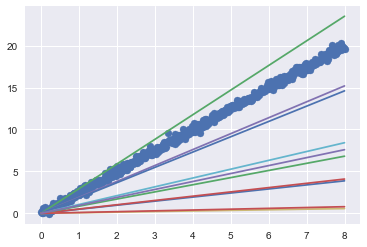

In [ ]:
# Posterior predictive checks.
y_post = ed.copy(y, {w: qw})

print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Displaying prior predictive samples.")
n_prior_samples = 10

w_prior = w.sample(n_prior_samples).eval()
# b_prior = b.sample(n_prior_samples).eval()

plt.scatter(X_train[:,0], y_train)

inputs = np.linspace(0, 8, num=400)
for ns in range(n_prior_samples):
    output = inputs * w_prior[ns][1]
    plt.plot(inputs, output)

plt.show()

Displaying posterior predictive samples.


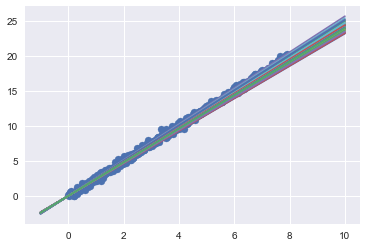

In [ ]:
print("Displaying posterior predictive samples.")
n_posterior_samples = 50

w_post = qw.sample(n_posterior_samples).eval()
# b_post = qb.sample(n_posterior_samples).eval()

plt.scatter(X_train[:,0], y_train)

inputs = np.linspace(-1, 10, num=400)
for ns in range(n_posterior_samples):
    output = inputs * w_post[ns,1] 
    plt.plot(inputs, output)

plt.show()

Inferred posterior mean:
[0.13712902 2.3368847 ]
Inferred posterior stddev:
[0.02733705 0.05828721]


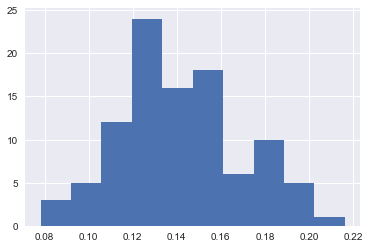

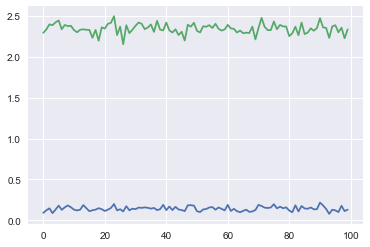

In [11]:
# CRITICISM
sess = ed.get_session()
mean, stddev = sess.run([qw.mean(), qw.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior stddev:")
print(stddev)

# Check convergence with visual diagnostics.
samples = sess.run(qw.sample(100))

# Plot histogram.
plt.hist(samples[:,0])
plt.show()

# Trace plot.
plt.plot(samples)
plt.show()

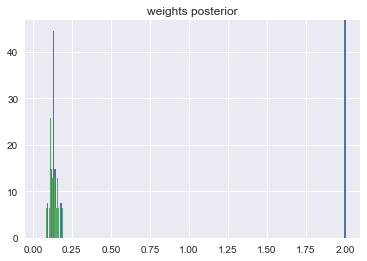

In [14]:
# weights posterior (regression parameters)

plt.hist(qw.sample(100).eval()[:,0],
         bins=100, normed=True)
plt.axvline(x=2)
plt.title('weights posterior')
plt.show()

In [15]:
# pass dictionary to tensorflow + iterate
sess.run({key: val for
          key, val in six.iteritems(qw.parameters)
          if isinstance(val, tf.Tensor)})

{'scale_tril': array([[0.02733705, 0.34547624],
        [0.03186195, 0.04880794]], dtype=float32)}

In [16]:
qw.parameters

{'allow_nan_stats': True,
 'loc': <tf.Variable 'qw/loc:0' shape=(2,) dtype=float32_ref>,
 'name': 'MultivariateNormalTriL_1/',
 'scale_tril': <tf.Tensor 'Softplus:0' shape=(2, 2) dtype=float32>,
 'validate_args': False}

In [17]:
def mvn_plot_contours(z, label=False, ax=None):
    """Plot the contours of 2-d Normal or MultivariateNormal object.
    Scale the axes to show 3 standard deviations.
    """
    sess = ed.get_session()
    mu = sess.run(z.parameters['loc'])
    mu_x, mu_y = mu
    Sigma = sess.run(z.parameters['scale_tril'])
    sigma_x, sigma_y = np.sqrt(Sigma[0, 0]), np.sqrt(Sigma[1, 1])
    xmin, xmax = mu_x - 3 * sigma_x, mu_x + 3 * sigma_x
    ymin, ymax = mu_y - 3 * sigma_y, mu_y + 3 * sigma_y
    xs = np.linspace(xmin, xmax, num=100)
    ys = np.linspace(ymin, ymax, num=100)
    X, Y = np.meshgrid(xs, ys)
    T = tf.cast(np.c_[X.flatten(), Y.flatten()], dtype=tf.float32)
    Z = sess.run(tf.exp(z.log_prob(T))).reshape((len(xs), len(ys)))
    if ax is None:
        fig, ax = plt.subplots()
    cs = ax.contour(X, Y, Z)
    if label:
        plt.clabel(cs, inline=1, fontsize=10)

In [18]:
sess.run(w.parameters['scale_tril'])

array([[1.       , 0.       ],
       [0.2      , 0.9797959]], dtype=float32)

In [19]:
sess.run(w.parameters['scale_tril'])

array([[1.       , 0.       ],
       [0.2      , 0.9797959]], dtype=float32)

In [20]:
qw.eval()

array([0.09778696, 2.2974868 ], dtype=float32)

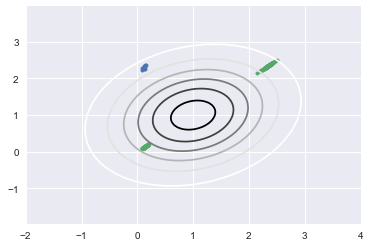

In [21]:
# fig, ax = plt.subplots()
# trace = sess.run(qw.sample(10).eval())
# ax.scatter(trace[:, 0], trace[:, 1], marker=".")
# ax.scatter(samples, samples, marker=".")
# mvn_plot_contours(w, ax=ax)
# plt.show()

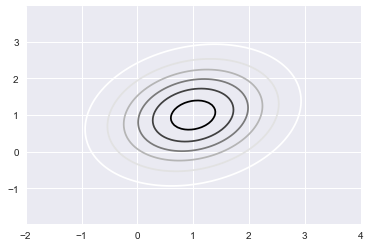

In [22]:
fig, ax = plt.subplots()
mvn_plot_contours(w, ax=ax)
plt.show()

In [24]:
Sigma = sess.run(w.parameters['scale_tril'])
Sigma

array([[1.       , 0.       ],
       [0.2      , 0.9797959]], dtype=float32)

In [28]:
sns.pairplot(qw.sample(100).eval(), size = 4)

IndexError: arrays used as indices must be of integer (or boolean) type